# Exploratory Data Analysis

## Import of Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from scipy import stats

In [2]:
cwd = Path().cwd()
data = cwd / 'Sleep-Health-Lifestyle-Dataset'
data_csv = list(data.iterdir())[0]
df = pd.read_csv(data_csv)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [4]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No Sleep Disorder')

In [5]:
df.sample(10, random_state=42)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
329,330,Female,53,Engineer,8.5,9,30,3,Normal,125/80,65,5000,No Sleep Disorder
33,34,Male,31,Doctor,6.1,6,30,8,Normal,125/80,72,5000,No Sleep Disorder
15,16,Male,29,Doctor,6.0,6,30,8,Normal,120/80,70,8000,No Sleep Disorder
325,326,Female,53,Engineer,8.5,9,30,3,Normal,125/80,65,5000,No Sleep Disorder
57,58,Male,32,Doctor,6.0,6,30,8,Normal,125/80,72,5000,No Sleep Disorder
239,240,Male,44,Salesperson,6.4,6,45,7,Overweight,130/85,72,6000,Insomnia
76,77,Male,33,Doctor,6.0,6,30,8,Normal,125/80,72,5000,No Sleep Disorder
119,120,Female,37,Accountant,7.2,8,60,4,Normal,115/75,68,7000,No Sleep Disorder
332,333,Female,54,Engineer,8.4,9,30,3,Normal,125/80,65,5000,No Sleep Disorder
126,127,Male,38,Lawyer,7.3,8,60,5,Normal,130/85,68,8000,No Sleep Disorder


In [6]:
df[['bp_systolic', 'bp_diastolic']] = (df['Blood Pressure']
                                       .str
                                       .split('/', expand=True)
                                       .astype(int))

In [7]:
df = df.drop(columns=['Person ID', 'Blood Pressure'])

In [8]:
df.describe(include='all')

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,bp_systolic,bp_diastolic
count,374,374.000000,374,374.000000,374.000000,374.000000,374.000000,374,374.000000,374.000000,374,374.000000,374.000000
unique,2,NaN,11,NaN,NaN,NaN,NaN,4,NaN,NaN,3,NaN,NaN
top,Male,NaN,Nurse,NaN,NaN,NaN,NaN,Normal,NaN,NaN,No Sleep Disorder,NaN,NaN
freq,189,NaN,73,NaN,NaN,NaN,NaN,195,NaN,NaN,219,NaN,NaN
mean,NaN,42.184492,NaN,7.132086,7.312834,59.171123,5.385027,NaN,70.165775,6816.844920,NaN,128.553476,84.649733
std,NaN,8.673133,NaN,0.795657,1.196956,20.830804,1.774526,NaN,4.135676,1617.915679,NaN,7.748118,6.161611
min,NaN,27.000000,NaN,5.800000,4.000000,30.000000,3.000000,NaN,65.000000,3000.000000,NaN,115.000000,75.000000
25%,NaN,35.250000,NaN,6.400000,6.000000,45.000000,4.000000,NaN,68.000000,5600.000000,NaN,125.000000,80.000000
50%,NaN,43.000000,NaN,7.200000,7.000000,60.000000,5.000000,NaN,70.000000,7000.000000,NaN,130.000000,85.000000
75%,NaN,50.000000,NaN,7.800000,8.000000,75.000000,7.000000,NaN,72.000000,8000.000000,NaN,135.000000,90.000000


## Class Distribution

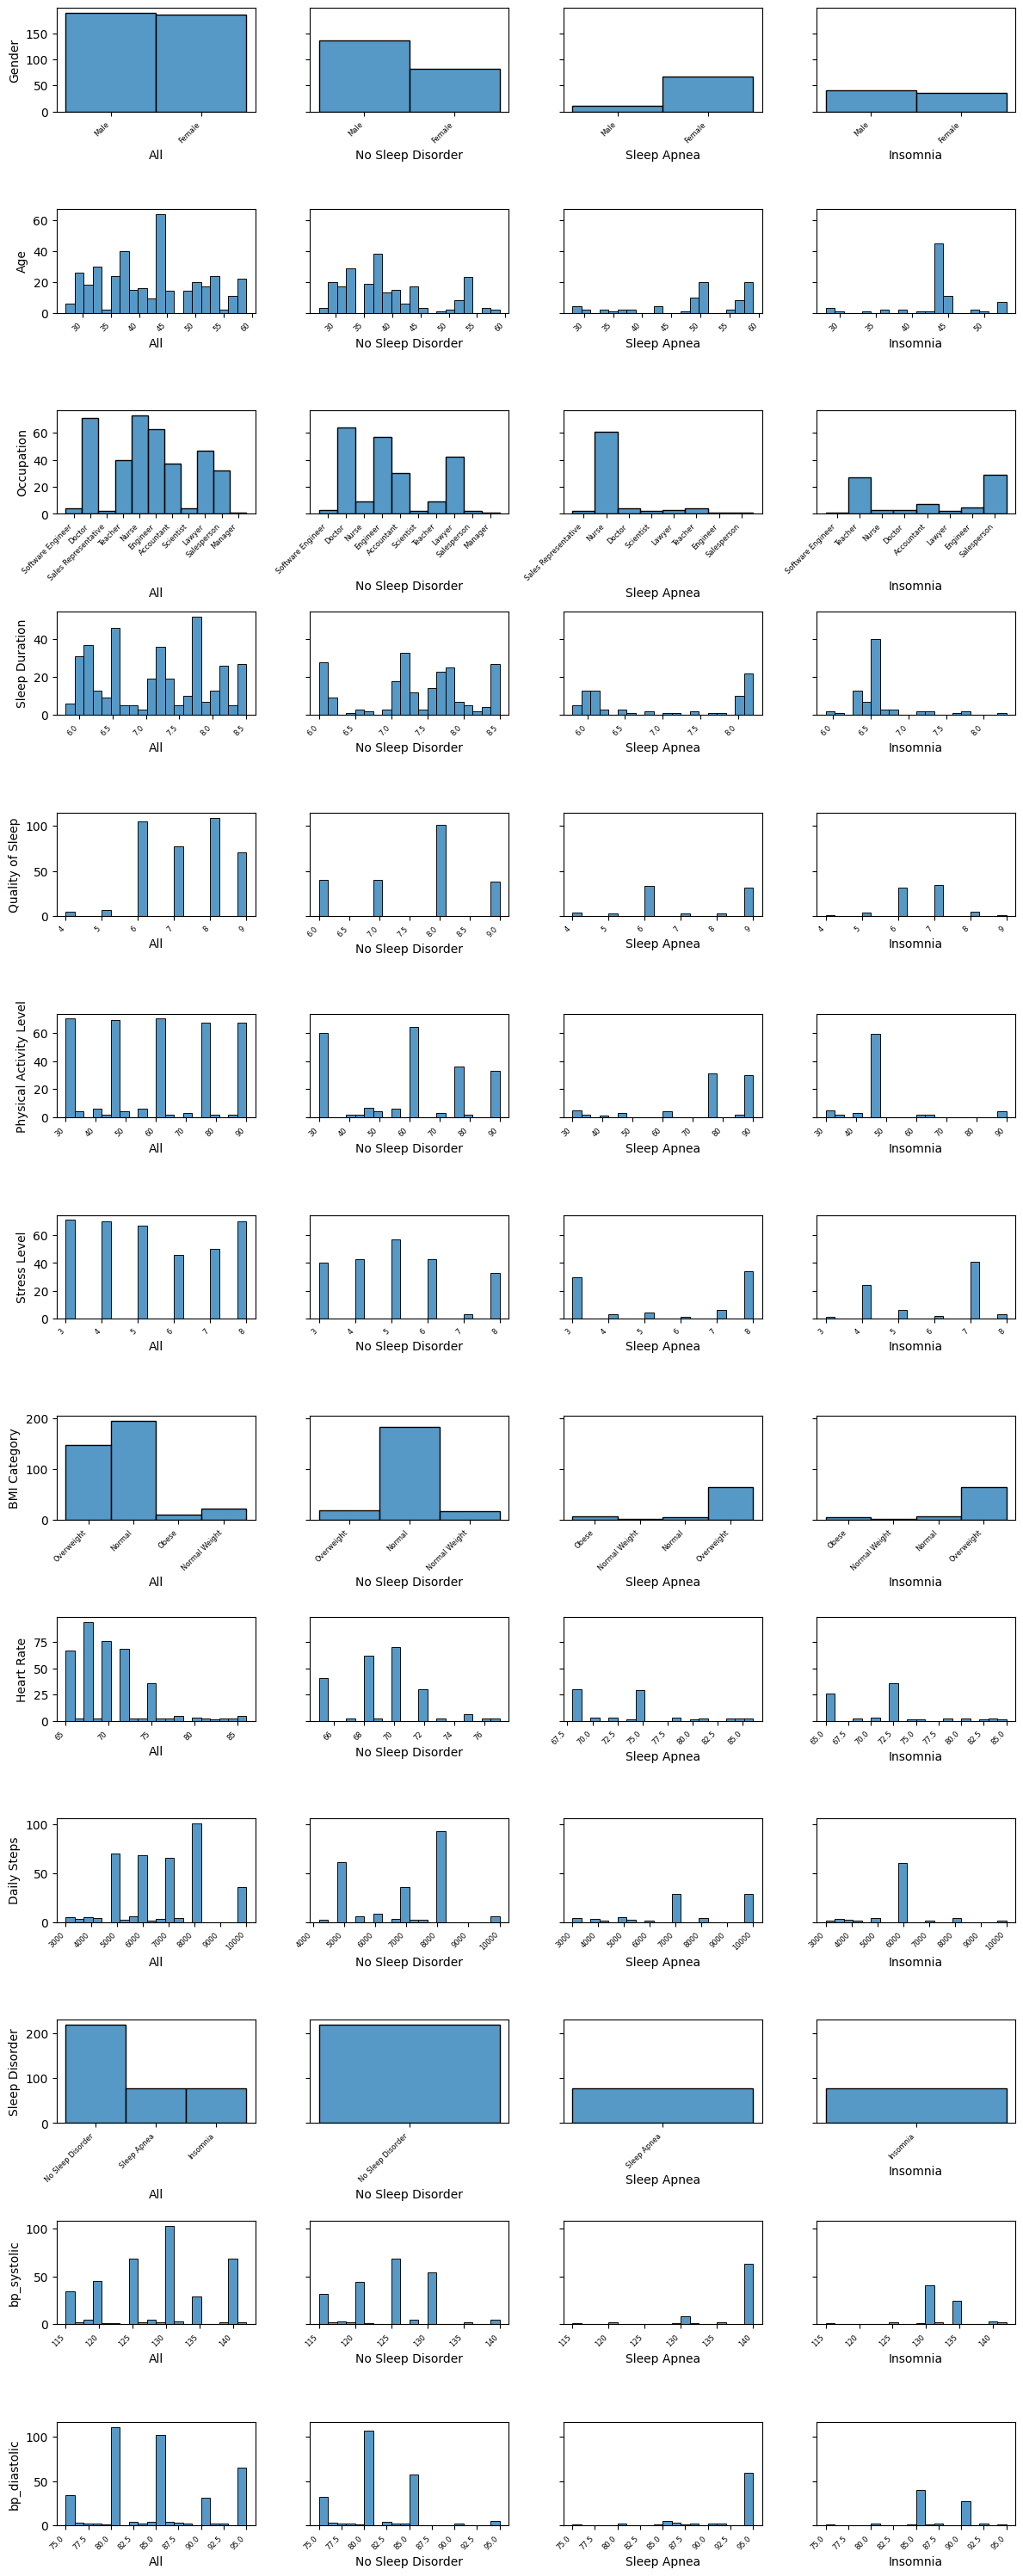

In [9]:
sleep_disorders = ['All'] + df['Sleep Disorder'].unique().tolist()
dataframes = [df] + [df[df['Sleep Disorder'] == x] for x in sleep_disorders[1:]]

x, axes = plt.subplots(nrows=len(df.columns), ncols=4, figsize=(12, 30), sharey='row')
axes = axes.flatten()
col_multiplied = np.array([[x, x, x, x] for x in df.columns]).reshape(-1)
for col, (index, ax)in zip(col_multiplied, enumerate(axes)):
    if (index + 1) % 4 == 1:
        df_use = dataframes[0]
        name = sleep_disorders[0]
    if (index + 1) % 4 == 2:
        df_use = dataframes[1]
        name = sleep_disorders[1]
    if (index + 1) % 4 == 3:
        df_use = dataframes[2]
        name = sleep_disorders[2]
    if (index + 1) % 4 == 0:
        df_use = dataframes[3]
        name = sleep_disorders[3]

    if (df_use[col].dtype == 'int64') or (df_use[col].dtype == 'float64'):
        bins = 20
    else:
        bins = 'auto'

    sns.histplot(df_use, x=col, ax=ax, bins=bins)
    ax.set_ylabel(col, fontsize=10)
    ax.set_xlabel(name, fontsize=10)
    ax.tick_params(axis='x', labelrotation=45, labelsize=6)

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

plt.tight_layout()  

<Axes: >

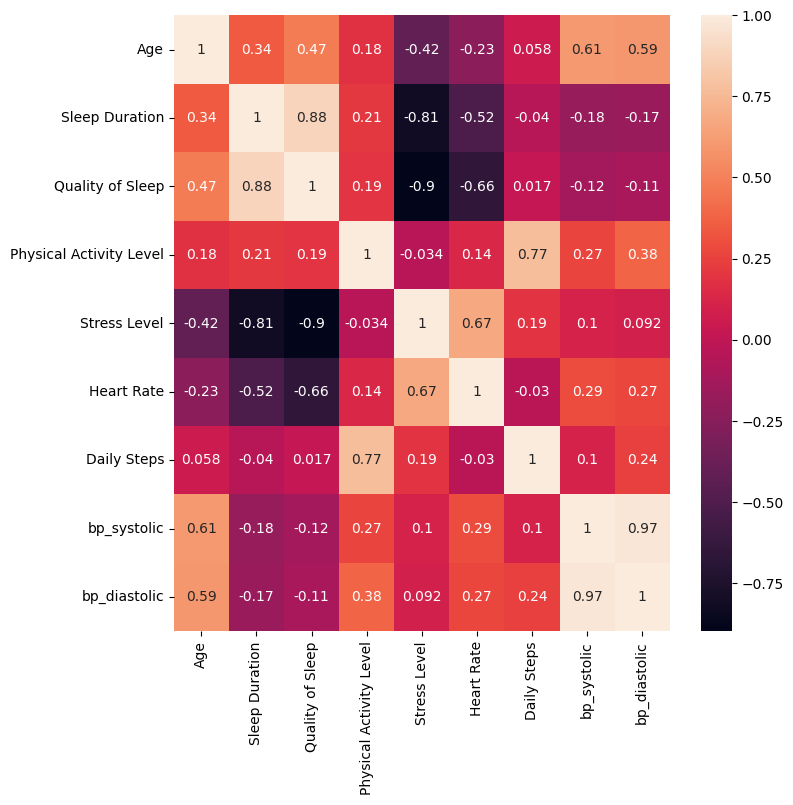

In [10]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [11]:
# df = df.drop(columns=['Daily Steps', 'Quality of Sleep', 'Stress Level', 'bp_diastolic'])

In [12]:
X = df.copy().drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder'].copy()
display(X.sample(10, random_state=42))
display(y.sample(10, random_state=42))

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,bp_systolic,bp_diastolic
329,Female,53,Engineer,8.5,9,30,3,Normal,65,5000,125,80
33,Male,31,Doctor,6.1,6,30,8,Normal,72,5000,125,80
15,Male,29,Doctor,6.0,6,30,8,Normal,70,8000,120,80
325,Female,53,Engineer,8.5,9,30,3,Normal,65,5000,125,80
57,Male,32,Doctor,6.0,6,30,8,Normal,72,5000,125,80
239,Male,44,Salesperson,6.4,6,45,7,Overweight,72,6000,130,85
76,Male,33,Doctor,6.0,6,30,8,Normal,72,5000,125,80
119,Female,37,Accountant,7.2,8,60,4,Normal,68,7000,115,75
332,Female,54,Engineer,8.4,9,30,3,Normal,65,5000,125,80
126,Male,38,Lawyer,7.3,8,60,5,Normal,68,8000,130,85


329    No Sleep Disorder
33     No Sleep Disorder
15     No Sleep Disorder
325    No Sleep Disorder
57     No Sleep Disorder
239             Insomnia
76     No Sleep Disorder
119    No Sleep Disorder
332    No Sleep Disorder
126    No Sleep Disorder
Name: Sleep Disorder, dtype: object

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Baseline Model: Logistic Regression

## Train

In [14]:
object_col = [col for col in df.columns if df[col].dtype == 'object' and col != 'Sleep Disorder']
int_col = [col for col in df.columns if df[col].dtype == 'int64']
float_col = [col for col in df.columns if df[col].dtype == 'float64']

In [52]:
preprocess = ColumnTransformer(
    [
        (
            'onehotencoder', 
            OneHotEncoder(
                handle_unknown='infrequent_if_exist', 
                sparse_output=False,
                min_frequency=0.02
            ), 
            object_col
        ),
        (
            'standardscaler', 
            StandardScaler(), 
            float_col + int_col
        )
    ], 
).set_output(transform='pandas')

pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.02,
                                                                sparse_output=False),
                                                  ['Gender', 'Occupation',
                                                   'BMI Category']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Sleep Duration', 'Age',
                                                   'Quality of Sleep',
                                                   'Physical Activity Level',
                                                   'Stress Level', 'Heart Rate',
                                                   'Daily Steps', 'bp_systolic',
                                                   'bp_diastolic'])])),
                ('model', LogisticRegression(random_state=42))])

## Metrics

In [53]:
pd.DataFrame(
    classification_report(
        y_test, 
        pipeline.predict(X_test), 
        output_dict=True
    )
)

,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.92,1.00,0.80,0.93,0.91,0.94
recall,0.80,0.95,1.00,0.93,0.92,0.93
f1-score,0.86,0.98,0.89,0.93,0.91,0.93
support,15.00,44.00,16.00,0.93,75.00,75.00


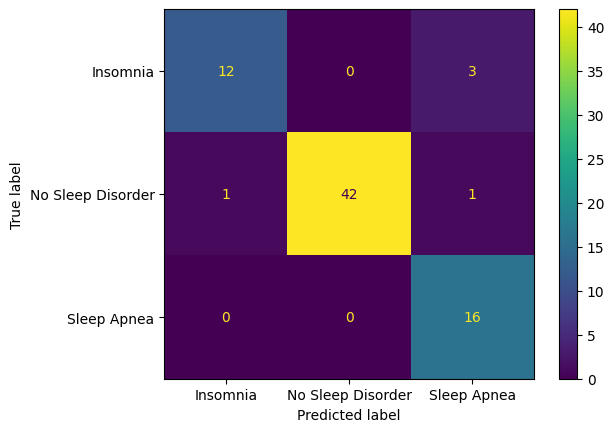

In [54]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

# Model: Optimized Logistic Regression

## Train

In [59]:
preprocess = ColumnTransformer(
    [
        (
            'onehotencoder', 
            OneHotEncoder(
                handle_unknown='infrequent_if_exist', 
                sparse_output=False,
                min_frequency=0.02
            ), 
            object_col
        ),
        (
            'standardscaler', 
            StandardScaler(), 
            float_col + int_col
        )
    ], 
).set_output(transform='pandas')

pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(random_state=42))
])

param_distributions = {
    'model__penalty': [None, 'l1', 'l2', 'elasticnet'],
    # 'model__penalty': ['l1', 'elasticnet'],
    'model__C': stats.loguniform(0.01, 100),
    'model__fit_intercept': [True, False],
    'model__intercept_scaling': stats.uniform(0.001, 0.999),
    'model__solver': ['saga'],
    'model__class_weight': [None, 'balanced'],
    'model__max_iter': [1000],
    'model__l1_ratio': stats.uniform(0.001, 0.999),   
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rscv = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='f1_weighted',
    cv=cv,
    verbose=0,
    random_state=42,
    return_train_score=True,
    n_jobs=-1
)

rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                             min_frequency=0.02,
                                                                                             sparse_output=False),
                                                                               ['Gender',
                                                                                'Occupation',
                                                                                'BMI '
                                                                                'Category']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['Sleep '
                                                                                'Durat...
                                        'model__intercept_scaling': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F5A8D3CFB0>,
                                        'model__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F5A909E870>,
                                        'model__max_iter': [1000],
                                        'model__penalty': ['l1', 'elasticnet'],
                                        'model__solver': ['saga']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [60]:
rscv.best_params_

{'model__C': np.float64(0.9499072859745388),
 'model__class_weight': None,
 'model__fit_intercept': False,
 'model__intercept_scaling': np.float64(0.5499793534414118),
 'model__l1_ratio': np.float64(0.44208897087200366),
 'model__max_iter': 1000,
 'model__penalty': 'l1',
 'model__solver': 'saga'}

## Metrics

In [61]:
pd.DataFrame(
    classification_report(
        y_test, 
        rscv.best_estimator_.predict(X_test), 
        output_dict=True
    )
)

,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,1.00,1.00,0.84,0.96,0.95,0.97
recall,0.87,0.98,1.00,0.96,0.95,0.96
f1-score,0.93,0.99,0.91,0.96,0.94,0.96
support,15.00,44.00,16.00,0.96,75.00,75.00


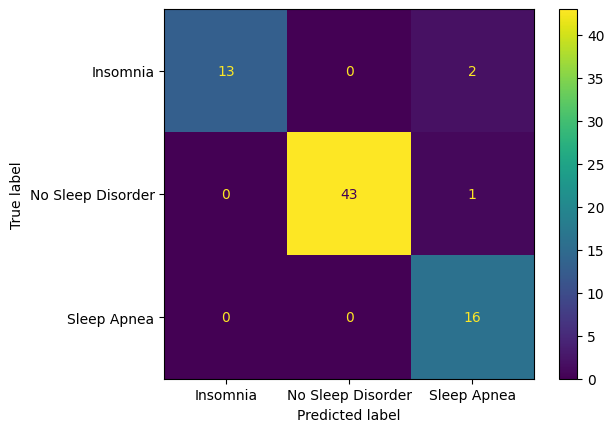

In [62]:
ConfusionMatrixDisplay.from_estimator(rscv.best_estimator_, X_test, y_test)

In [22]:
wt_dict = {'name': [], 'wt_Insomnia': [], 'wt_NSD': [], 'wt_SA': []}
for w1, w2, w3, name in zip(
    rscv.best_estimator_['model'].coef_[0],
    rscv.best_estimator_['model'].coef_[1], 
    rscv.best_estimator_['model'].coef_[2],  
    pipeline['preprocess'].fit_transform(X_train).columns
):
    wt_dict['name'].append(name)
    wt_dict['wt_Insomnia'].append(w1)
    wt_dict['wt_NSD'].append(w2)
    wt_dict['wt_SA'].append(w3)

pd.DataFrame(wt_dict)

,name,wt_Insomnia,wt_NSD,wt_SA
0,onehotencoder__Gender_Male,0.000000,0.251069,-0.729003
1,onehotencoder__Occupation_Doctor,-0.540526,1.810587,0.000000
2,onehotencoder__Occupation_Engineer,0.000000,0.641823,-1.257295
3,onehotencoder__Occupation_Lawyer,0.000000,1.509547,-0.294496
4,onehotencoder__Occupation_Nurse,-2.786480,0.386230,0.273826
5,onehotencoder__Occupation_Salesperson,0.536289,-0.227214,0.000000
6,onehotencoder__Occupation_Teacher,0.000000,-0.218495,0.504648
7,onehotencoder__Occupation_infrequent_sklearn,-1.200366,1.789950,0.000000
8,onehotencoder__BMI Category_Normal Weight,0.000000,0.225850,-1.456048
9,onehotencoder__BMI Category_Obese,0.000000,0.000000,0.000000


# Lazy Predict

In [40]:
from lazypredict.Supervised import LazyClassifier

In [63]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(
    X_train, 
    X_test,
    y_train,
    y_test
)


100%|██████████| 31/31 [00:00<00:00, 44.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 299, number of used features: 20
[LightGBM] [Info] Start training from score -1.573309
[LightGBM] [Info] Start training from score -0.535658
[LightGBM] [Info] Start training from score -1.573309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [64]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
CalibratedClassifierCV,0.97,0.96,None,0.97,0.04
SVC,0.97,0.96,None,0.97,0.01
ExtraTreeClassifier,0.96,0.95,None,0.96,0.01
LinearSVC,0.96,0.95,None,0.96,0.01
GaussianNB,0.95,0.94,None,0.95,0.01
KNeighborsClassifier,0.95,0.93,None,0.95,0.02
Perceptron,0.95,0.93,None,0.95,0.01
RandomForestClassifier,0.95,0.93,None,0.95,0.11
BaggingClassifier,0.93,0.92,None,0.93,0.03


## Visualization

In [90]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [92]:
lda = LinearDiscriminantAnalysis().set_output(transform='pandas')
df_lda = lda.fit_transform(preprocess.fit_transform(X), y)
combined = pd.concat([df_lda, pd.Series(y)], axis=1)
combined

,lineardiscriminantanalysis0,lineardiscriminantanalysis1,Sleep Disorder
0,-1.02,-1.26,No Sleep Disorder
1,-1.82,-0.51,No Sleep Disorder
2,-1.82,-0.51,No Sleep Disorder
3,2.74,-0.21,Sleep Apnea
4,2.74,-0.21,Sleep Apnea
...,...,...,...
369,2.39,-2.41,Sleep Apnea
370,2.35,-2.41,Sleep Apnea
371,2.39,-2.41,Sleep Apnea
372,2.39,-2.41,Sleep Apnea


In [93]:
lda.explained_variance_ratio_.cumsum()

array([0.63117133, 1.        ])

<Axes: xlabel='lineardiscriminantanalysis0', ylabel='lineardiscriminantanalysis1'>

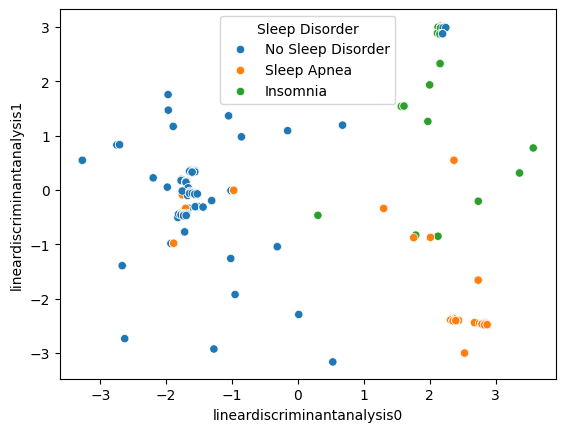

In [95]:
sns.scatterplot(combined, x='lineardiscriminantanalysis0', y='lineardiscriminantanalysis1', hue='Sleep Disorder')